# IndoBERT QAT (Quantization-Aware Training) Pipeline - 3-Label Classification

This notebook fine-tunes IndoBERT with Quantization-Aware Training (QAT) for INT8 quantization on 3-label sentiment analysis.

**QAT vs PTQ:**
- QAT: Quantization simulation during training (better accuracy)
- PTQ: Quantization applied after training (faster, simpler)

**Dataset:**
SMSA (Sentiment Analysis) from IndoNLU benchmark

**Labels:**
- Positive (0)
- Neutral (1)
- Negative (2)

**Pipeline:**
1. Load SMSA dataset (train/val/test TSV files)
2. Map text labels to numeric values
3. Load FP32 model and prepare for QAT
4. Fine-tune with fake quantization (INT8 simulation)
5. Convert to actual INT8
6. Evaluate quantized model

**Hyperparameters:**
- Learning rate: 2e-5
- Batch size: 16
- Epochs: 3
- Quantization: INT8 (simulated during training)
- Optimizer: AdamW
- Max sequence length: 128

In [17]:
# !pip install --upgrade numpy
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers datasets accelerate
# !pip install scikit-learn

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter
from torch.ao.quantization import QConfig
from torch.ao.quantization.observer import MovingAverageMinMaxObserver, MinMaxObserver

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.quantization as quantization
import os
import re

## Load Tokenizer

In [19]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
print(f"Tokenizer loaded: {tokenizer.__class__.__name__}")

c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizer loaded: BertTokenizerFast


## Define Tokenization Function

In [20]:
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

## Load SMSA Dataset

In [21]:
dataset = load_dataset(
    'csv',
    data_files={
        'train': 'train.tsv',
        'validation': 'valid.tsv',
        'test': 'test.tsv'
    },
    delimiter='\t',
    column_names=['text', 'label']
)

print(f"Train samples: {len(dataset['train']):,}")
print(f"Validation samples: {len(dataset['validation']):,}")
print(f"Test samples: {len(dataset['test']):,}")
print(f"\nColumns: {dataset['train'].column_names}")
print(f"\nSample: {dataset['train'][0]}")
print(f"\nLabel distribution in training set:")

label_counts = Counter(dataset['train']['label'])
for label, count in label_counts.items():
    print(f"  {label}: {count}")

Train samples: 11,000
Validation samples: 1,260
Test samples: 500

Columns: ['text', 'label']

Sample: {'text': 'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !', 'label': 'positive'}

Label distribution in training set:
  positive: 6416
  neutral: 1148
  negative: 3436


## Map Labels to Numeric Values

In [22]:
# label mapping
label2id = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}
id2label = {
    0: 'positive',
    1: 'neutral',
    2: 'negative'
}

print("Label mapping:")
for label, idx in label2id.items():
    print(f"  {label} -> {idx}")

def map_labels(df):
    df['label'] = [label2id[label] for label in df['label']]
    return df

dataset = dataset.map(
    map_labels,
    batched=True,
    desc="Mapping labels to numeric values"
)

print("\nAfter mapping, sample label:", dataset['train'][0]['label'])
print(f"Label type: {type(dataset['train'][0]['label'])}")

Label mapping:
  positive -> 0
  neutral -> 1
  negative -> 2

After mapping, sample label: 0
Label type: <class 'int'>


## Load FP32 Model and Prepare for QAT

In [23]:
model_fp32 = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p2",
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

print(f"FP32 Model loaded: {model_fp32.__class__.__name__}")
print(f"Number of parameters: {model_fp32.num_parameters():,}")
print(f"Number of labels: {model_fp32.config.num_labels}")
print(f"Label mapping: {model_fp32.config.label2id}")

# switch model to training from eval mode to apply QAT
model_fp32.train()

# Create custom QConfig with per-tensor quantization
qat_qconfig = QConfig(
    activation=MovingAverageMinMaxObserver.with_args(
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine  # Use per-tensor instead of per-channel
    ),
    weight=MinMaxObserver.with_args(
        dtype=torch.qint8,
        qscheme=torch.per_tensor_symmetric  # Use per-tensor symmetric
    )
)

# Apply config to model
model_fp32.qconfig = qat_qconfig

# Skip quantization for embedding and LayerNorm layers
def set_qconfig_for_layers(module, qconfig):
    """Set qconfig for appropriate layers only"""
    for name, child in module.named_children():
        if isinstance(child, (torch.nn.Embedding, torch.nn.LayerNorm)):
            child.qconfig = None
            print(f"Skipping quantization for: {name} ({child.__class__.__name__})")
        else:
            child.qconfig = qconfig
            set_qconfig_for_layers(child, qconfig)

set_qconfig_for_layers(model_fp32, qat_qconfig)

# prepare model for QAT (inserts fake quantization modules)
model_qat = quantization.prepare_qat(model_fp32, inplace=False)

print(f"\nModel prepared for QAT")
print(f"Fake quantization modules inserted")
print(f"Model will simulate INT8 quantization during training")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FP32 Model loaded: BertForSequenceClassification
Number of parameters: 124,443,651
Number of labels: 3
Label mapping: {'positive': 0, 'neutral': 1, 'negative': 2}
Skipping quantization for: word_embeddings (Embedding)
Skipping quantization for: position_embeddings (Embedding)
Skipping quantization for: token_type_embeddings (Embedding)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for: LayerNorm (LayerNorm)
Skipping quantization for

## Text Preprocessing

In [24]:
stopword_factory = StopWordRemoverFactory()
indonesian_stopwords = stopword_factory.get_stop_words()

print(f"Loaded {len(indonesian_stopwords)} Indonesian stop words")
print(f"Sample stop words: {list(indonesian_stopwords)[:10]}")

Loaded 126 Indonesian stop words
Sample stop words: ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua']


In [25]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # convert to lowercase
    text = text.lower()
    
    # remove non-alphabetic characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # remove stop words
    words = text.split()
    words = [word for word in words if word not in indonesian_stopwords]
    text = ' '.join(words)
    
    return text

sample_text = "Ini adalah contoh kalimat! Apakah preprocessing berfungsi? 123 #test"
print(f"Original: {sample_text}")
print(f"Preprocessed: {preprocess_text(sample_text)}")

Original: Ini adalah contoh kalimat! Apakah preprocessing berfungsi? 123 #test
Preprocessed: contoh kalimat preprocessing berfungsi test


In [26]:
print("Applying preprocessing to dataset...")
print("Before preprocessing:")
print(f"  Sample text: {dataset['train'][0]['text'][:100]}...")

def preprocess_dataset(examples):
    """Apply preprocessing to a batch of examples"""
    examples['text'] = [preprocess_text(text) for text in examples['text']]
    return examples

dataset = dataset.map(
    preprocess_dataset,
    batched=True,
    desc="Preprocessing text"
)

print("\nAfter preprocessing:")
print(f"  Sample text: {dataset['train'][0]['text'][:100]}...")
print("\nPreprocessing complete!")

Applying preprocessing to dataset...
Before preprocessing:
  Sample text: warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih ...

After preprocessing:
  Sample text: warung dimiliki pengusaha pabrik tahu puluhan tahun terkenal membuat tahu putih bandung tahu berkual...

Preprocessing complete!


## Tokenize Dataset

In [27]:
tokenized_dataset = dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=['text']
)

print("Tokenization complete!")
print(f"Columns after tokenization: {tokenized_dataset['train'].column_names}")
print(f"\nSample tokenized data:")
print(f"  input_ids length: {len(tokenized_dataset['train'][0]['input_ids'])}")
print(f"  attention_mask length: {len(tokenized_dataset['train'][0]['attention_mask'])}")

Map:   0%|          | 0/11000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenization complete!
Columns after tokenization: ['label', 'input_ids', 'token_type_ids', 'attention_mask']

Sample tokenized data:
  input_ids length: 128
  attention_mask length: 128


## Define Metrics Function

In [28]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Configure QAT Training Arguments

In [ ]:
output_dir = "./results/indobert-smsa-qat-int8"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir=f"{output_dir}/logs",
    logging_steps=100,
    report_to="none",
    fp16=False,
    push_to_hub=False
)

print("QAT Training arguments configured:")
print(f"  Output directory: {output_dir}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Quantization: INT8 (fake quant during training)")

QAT Training arguments configured:
  Output directory: ./results/indobert-smsa-qat-int8
  Learning rate: 2e-05
  Batch size: 16
  Epochs: 3
  Quantization: INT8 (fake quant during training)


## Initialize Trainer for QAT

In [30]:
trainer = Trainer(
    model=model_qat,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("QAT Trainer initialized successfully!")

QAT Trainer initialized successfully!


## Start QAT Training

In [31]:
print("Starting QAT training...")
print("Note: Training with fake quantization may be 10-20% slower than FP32")
print("="*70)

train_result = trainer.train()

print("\n" + "="*70)
print("QAT Training completed!")
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training runtime: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")

Starting QAT training...
Note: Training with fake quantization may be 10-20% slower than FP32


c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2064 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.481, 'learning_rate': 1.9031007751937985e-05, 'epoch': 0.15}
{'loss': 0.3566, 'learning_rate': 1.8062015503875972e-05, 'epoch': 0.29}
{'loss': 0.2986, 'learning_rate': 1.7093023255813955e-05, 'epoch': 0.44}
{'loss': 0.294, 'learning_rate': 1.612403100775194e-05, 'epoch': 0.58}
{'loss': 0.3176, 'learning_rate': 1.5155038759689924e-05, 'epoch': 0.73}
{'loss': 0.2768, 'learning_rate': 1.4186046511627909e-05, 'epoch': 0.87}


  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 0.29427239298820496, 'eval_accuracy': 0.8896825396825396, 'eval_precision': 0.8913376033580909, 'eval_recall': 0.8896825396825396, 'eval_f1': 0.8898923928032599, 'eval_runtime': 14.9964, 'eval_samples_per_second': 84.02, 'eval_steps_per_second': 5.268, 'epoch': 1.0}
{'loss': 0.2689, 'learning_rate': 1.3217054263565892e-05, 'epoch': 1.02}
{'loss': 0.1677, 'learning_rate': 1.2248062015503876e-05, 'epoch': 1.16}
{'loss': 0.2201, 'learning_rate': 1.1279069767441861e-05, 'epoch': 1.31}
{'loss': 0.1577, 'learning_rate': 1.0310077519379846e-05, 'epoch': 1.45}
{'loss': 0.1696, 'learning_rate': 9.34108527131783e-06, 'epoch': 1.6}
{'loss': 0.1856, 'learning_rate': 8.372093023255815e-06, 'epoch': 1.74}
{'loss': 0.1613, 'learning_rate': 7.403100775193799e-06, 'epoch': 1.89}


  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 0.30856966972351074, 'eval_accuracy': 0.8984126984126984, 'eval_precision': 0.8976674612735117, 'eval_recall': 0.8984126984126984, 'eval_f1': 0.8975624784296082, 'eval_runtime': 13.5857, 'eval_samples_per_second': 92.744, 'eval_steps_per_second': 5.815, 'epoch': 2.0}
{'loss': 0.1541, 'learning_rate': 6.434108527131784e-06, 'epoch': 2.03}
{'loss': 0.1125, 'learning_rate': 5.465116279069767e-06, 'epoch': 2.18}
{'loss': 0.0932, 'learning_rate': 4.4961240310077525e-06, 'epoch': 2.33}
{'loss': 0.0911, 'learning_rate': 3.527131782945737e-06, 'epoch': 2.47}
{'loss': 0.0764, 'learning_rate': 2.558139534883721e-06, 'epoch': 2.62}
{'loss': 0.1203, 'learning_rate': 1.5891472868217056e-06, 'epoch': 2.76}
{'loss': 0.1035, 'learning_rate': 6.201550387596899e-07, 'epoch': 2.91}


  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 0.3824440538883209, 'eval_accuracy': 0.9007936507936508, 'eval_precision': 0.9002370862048713, 'eval_recall': 0.9007936507936508, 'eval_f1': 0.9004370715467654, 'eval_runtime': 13.3473, 'eval_samples_per_second': 94.401, 'eval_steps_per_second': 5.919, 'epoch': 3.0}
{'train_runtime': 1040.6142, 'train_samples_per_second': 31.712, 'train_steps_per_second': 1.983, 'train_loss': 0.2014281939166461, 'epoch': 3.0}

QAT Training completed!
Training loss: 0.2014
Training runtime: 1040.61 seconds
Training samples/second: 31.71


In [ ]:
# model_qat.eval()
# model_int8 = quantization.convert(model_qat, inplace=False)

# print("Model converted to INT8")
# print(f"INT8 model parameters: {model_int8.num_parameters():,}")
# print("\nModel now uses actual INT8 operations instead of fake quantization")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(
                in_features=768, out_features=768, bias=True
                (weight_fake_quant): MinMaxObserver(min_val=-0.09858351200819016, max_val=0.10384736210107803)
                (activation_post_process): MovingAverageMinMaxObserver(min_val=-4.042253494262695, max_val=4.5835771560668945)
              )
              (key): Linear(
                in_features=768, out_features=768, bias=True
                (weight_fake_quant):

## Evaluate INT8 (fake-quant) Model on Test Set

In [ ]:
model_qat.eval()

print("Evaluating QAT (fake-quant) model on test set")
test_results = trainer.evaluate(tokenized_dataset['test'])

print("\nQAT INT8 Test Set Results:")
print("="*70)
print(f"  Accuracy:  {test_results['eval_accuracy']:.4f}")
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall:    {test_results['eval_recall']:.4f}")
print(f"  F1 Score:  {test_results['eval_f1']:.4f}")
print("="*70)

Evaluating QAT INT8 model on test set...


c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/32 [00:00<?, ?it/s]


QAT INT8 Test Set Results:
  Accuracy:  0.8760
  Precision: 0.8798
  Recall:    0.8760
  F1 Score:  0.8736


c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/32 [00:00<?, ?it/s]

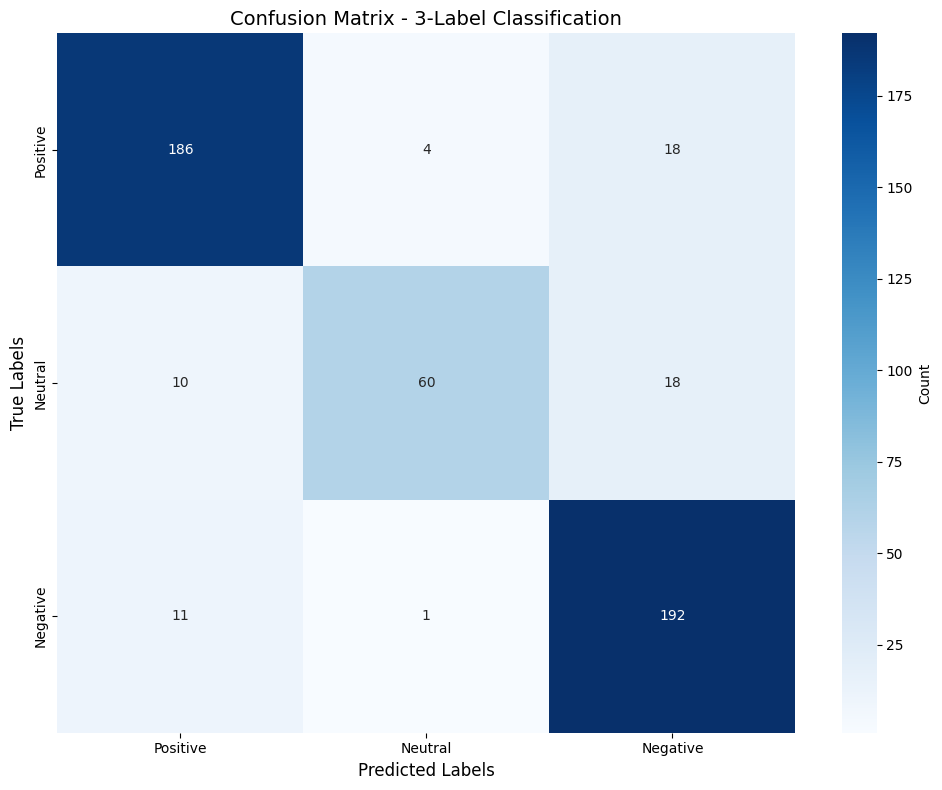


Detailed Classification Report:
              precision    recall  f1-score   support

    Positive       0.90      0.89      0.90       208
     Neutral       0.92      0.68      0.78        88
    Negative       0.84      0.94      0.89       204

    accuracy                           0.88       500
   macro avg       0.89      0.84      0.86       500
weighted avg       0.88      0.88      0.87       500



In [ ]:
predictions_output = trainer.predict(tokenized_dataset['test'])
y_pred = predictions_output.predictions.argmax(-1)
y_true = predictions_output.label_ids
cm = confusion_matrix(y_true, y_pred)

label_names = ['Positive', 'Neutral', 'Negative']

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, 
            yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix - 3-Label Classification", fontsize=14)
plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report
print("\nDetailed Classification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=label_names))
print("="*70)

## Save QAT INT8 (Fake Quant) Model

In [ ]:
save_path_qat = "./models/indobert-smsa-qat-int8"
os.makedirs(save_path_qat, exist_ok=True)

model_qat.save_pretrained(save_path_qat)
tokenizer.save_pretrained(save_path_qat)

print(f"QAT INT8 (Fake Quant) model saved to: {save_path_qat}")
print("\nTo load the model later:")
print(f"  model = AutoModelForSequenceClassification.from_pretrained('{save_path_qat}')")
print(f"  tokenizer = AutoTokenizer.from_pretrained('{save_path_qat}')")
print(f"\nModel configuration:")
print(f"  - num_labels: 3")
print(f"  - label mapping: {label2id}")

QAT INT8 model saved to: ./models/indobert-smsa-qat-int8

To load the model later:
  model = AutoModelForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=3)
  model.load_state_dict(torch.load('./models/indobert-smsa-qat-int8/model_int8.pth'))
  tokenizer = AutoTokenizer.from_pretrained('./models/indobert-smsa-qat-int8')


## Model Size Comparison

In [65]:
int8_size = os.path.getsize(f"{save_path_qat}/model_int8.pth") / (1024 * 1024)

print("Model Size Comparison:")
print("="*70)
print(f"QAT INT8 model: {int8_size:.2f} MB")
print(f"Expected FP32 size: ~{int8_size * 4:.2f} MB")
print(f"Size reduction: ~{(1 - int8_size / (int8_size * 4)) * 100:.1f}%")
print("="*70)

Model Size Comparison:
QAT INT8 model: 230.16 MB
Expected FP32 size: ~920.63 MB
Size reduction: ~75.0%
